In [1]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import scvi

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu 
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import TissueGraph_basics as tgh
# from dredFISH.Analysis import powerplots

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'

# allen data
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'

In [4]:
%%time

# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)

# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
ref_data

CPU times: user 505 ms, sys: 11.4 s, total: 11.9 s
Wall time: 11.9 s


AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [5]:
ref_data.obs = ref_data.obs.rename({
                                    'class_label': 'Level_1_class_label',
                                    'neighborhood_label': 'Level_2_neighborhood_label',
                                    'subclass_label': 'Level_3_subclass_label',
                                    'cluster_label': 'Level_5_cluster_label',
                                    }, axis=1)
ref_data

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

In [6]:
def get_umap(Xcell, Ycell, 
             Xidx, Yidx, 
             Xname, Yname,
             **kwargs):
    """
    """
    # run UMAP
    embed = umap.UMAP(**kwargs).fit_transform(
        np.vstack([Xcell, Ycell])
        )

    dfembed = pd.DataFrame(index=np.hstack([Xidx, Yidx])) 
    dfembed['dataset'] = [Xname]*len(Xidx) + [Yname]*len(Yidx) 
    dfembed['embed_1'] = embed[:,0]
    dfembed['embed_2'] = embed[:,1]
    
    return dfembed 

In [7]:
adata_merged = ref_data.copy()
adata_merged

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

In [12]:
adata_merged.X = adata_merged.X.astype(int) # within the support of Poisson

In [13]:
scvi.model.SCVI.setup_anndata(adata_merged, layer=None, batch_key=None)

In [14]:
vae = scvi.model.SCVI(adata_merged, n_layers=2, n_latent=10, gene_likelihood="poisson")

In [15]:
%%time
vae.train()

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


Epoch 109/109: 100%|██████████| 109/109 [1:32:00<00:00, 50.64s/it, loss=9.07e+04, v_num=1]
CPU times: user 1d 23h 34min 6s, sys: 1h 28min 45s, total: 2d 1h 2min 51s
Wall time: 1h 32min


In [16]:
adata_merged.obsm["X_scVI"] = vae.get_latent_representation()
adata_merged.obsm['X_scVI'].shape

(73347, 10)

In [17]:
# sc.pp.neighbors(adata, use_r/bigstore/X_scVI")
# sc.tl.leiden(adata)

In [18]:
# from scvi.model.utils import mde
# import pymde
adata_merged.obsm["X_umap"] = umap.UMAP(verbose=True).fit_transform(adata_merged.obsm["X_scVI"])

UMAP( verbose=True)
Wed Apr 20 10:10:43 2022 Construct fuzzy simplicial set
Wed Apr 20 10:10:43 2022 Finding Nearest Neighbors
Wed Apr 20 10:10:43 2022 Building RP forest with 19 trees
Wed Apr 20 10:10:44 2022 NN descent for 16 iterations
Epoch 1/109:   0%|          | 0/109 [1:39:02<?, ?it/s]
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Apr 20 10:10:58 2022 Finished Nearest Neighbor Search
Wed Apr 20 10:11:02 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Apr 20 10:12:23 2022 Finished embedding


In [20]:
adata_merged

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

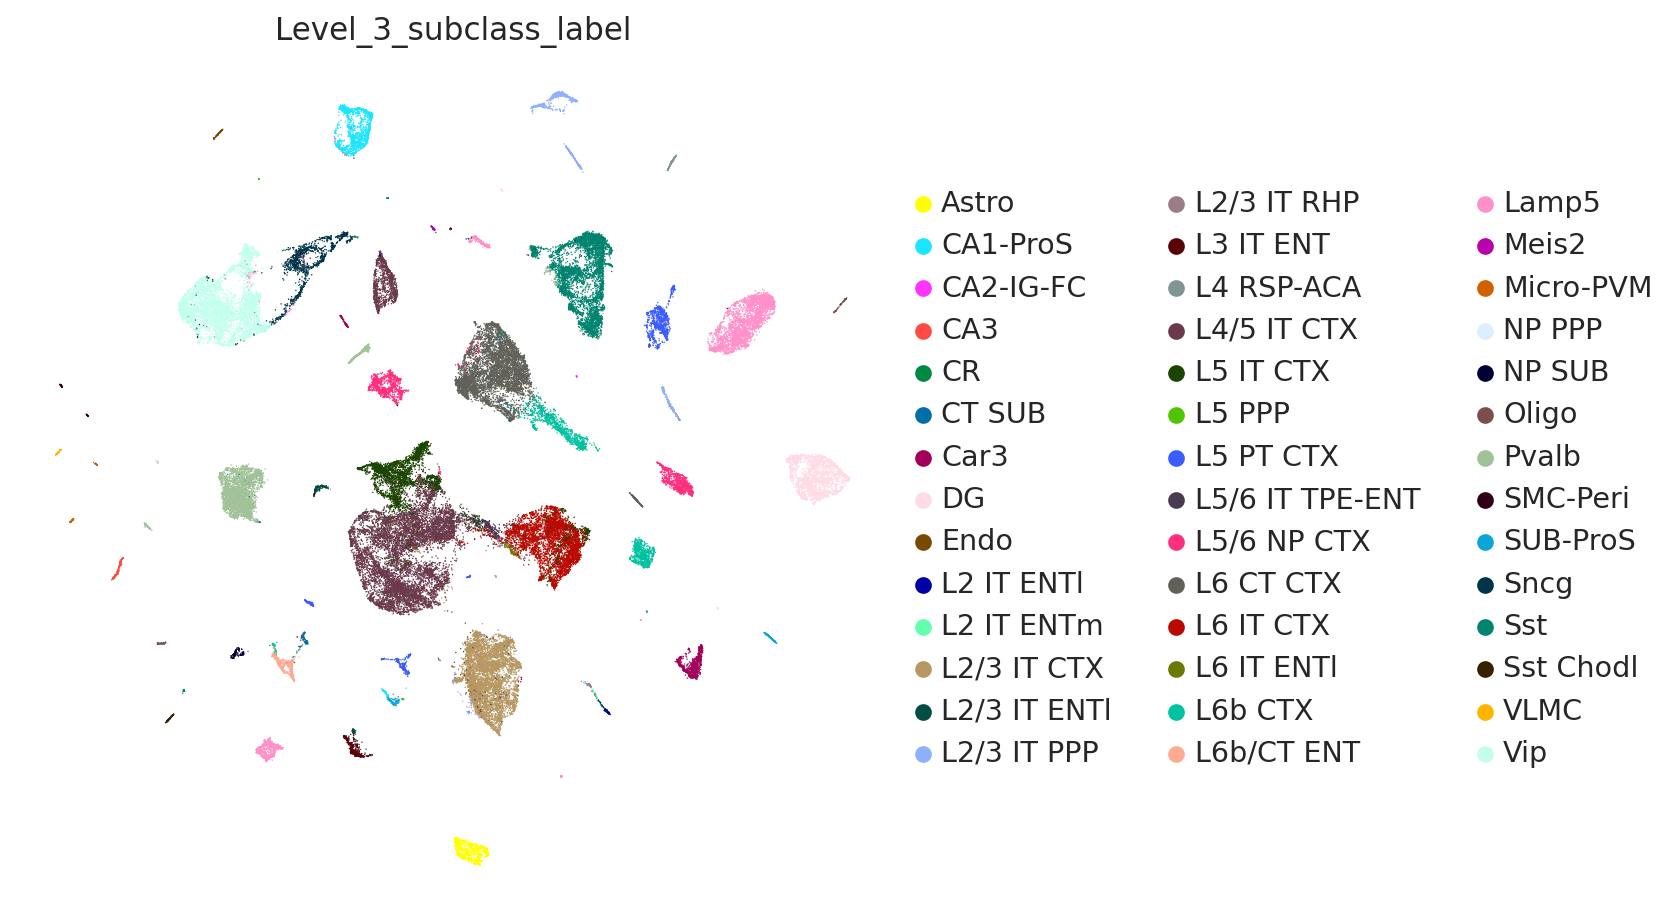

In [21]:
sc.pl.embedding(
    adata_merged, 
    basis="X_umap",
    color=["Level_3_subclass_label"], 
    frameon=False, 
    ncols=1, 
)

In [22]:
# save adata_merged
output = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_scVI_matrix.h5ad'

In [23]:
%%time
infile = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_scVI_matrix.h5ad'
checkin = anndata.read(infile)

In [25]:
checkin

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

In [27]:
# anndata.__version__

'0.8.0'

In [29]:
output_scvi = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_scvi_matrix.npy'
np.save(output_scvi, checkin.obsm['X_scVI'])

In [31]:
output_scvi_umap = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_scvi_umap_matrix.npy'
np.save(output_scvi_umap, checkin.obsm['X_umap'])